Version 1.0.1

# Check your versions

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.13.1
pandas 0.20.3
scipy 0.19.1
sklearn 0.19.0
lightgbm 2.0.6


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

And use only 3 shops for simplicity.

In [4]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

In [5]:
sales.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
15036,05.01.2013,0,28,7738,199.0,1.0
15037,07.01.2013,0,28,7738,199.0,1.0
15038,19.01.2013,0,28,7738,199.0,1.0


# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [6]:
# 1行ずつ実行

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### 以下、1行ずつ実行

In [6]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [7]:
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [9]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}}) # as_index=False でreset_indexをやったのと同じになる

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [12]:
gb.head(3)

,shop_id,item_id,date_block_num,item_cnt_day
,,,,target
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0


In [11]:
print(gb.columns.values)

[('shop_id', '') ('item_id', '') ('date_block_num', '')
 ('item_cnt_day', 'target')]


In [13]:
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

In [14]:
print(gb.columns.values)

['shop_id' 'item_id' 'date_block_num' 'target']


In [15]:
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [16]:
# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [17]:
all_data.head(3)

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,28,7738,0,4.0,7057.0,11.0
1,28,7737,0,10.0,7057.0,16.0
2,28,7770,0,6.0,7057.0,10.0


In [18]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)

In [19]:
del grid, gb 

In [20]:
gc.collect();

### 1行ずつ実行、ここまで

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [7]:
# 以下、1行ずつ実行する
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

A Jupyter Widget

In [42]:
# index_cols

['shop_id', 'item_id', 'date_block_num']

In [41]:
# all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item'],
      dtype='object')

In [43]:
# all_data.columns.difference(index_cols)

Index(['target', 'target_item', 'target_shop'], dtype='object')

In [21]:
# List of columns that we will use to create lags
# index_cols以外の列
cols_to_rename = list(all_data.columns.difference(index_cols))
cols_to_rename

['target', 'target_item', 'target_shop']

In [45]:
# cols_to_rename

['target', 'target_item', 'target_shop']

In [22]:
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy() #index_cols = ['shop_id', 'item_id', 'date_block_num']
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

A Jupyter Widget

In [23]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

In [24]:
all_data.head(3)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
120669,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120670,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0
120671,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0


In [12]:
# [col for col in all_data.columns]

['shop_id',
 'item_id',
 'date_block_num',
 'target',
 'target_shop',
 'target_item',
 'target_lag_1',
 'target_item_lag_1',
 'target_shop_lag_1',
 'target_lag_2',
 'target_item_lag_2',
 'target_shop_lag_2',
 'target_lag_3',
 'target_item_lag_3',
 'target_shop_lag_3',
 'target_lag_4',
 'target_item_lag_4',
 'target_shop_lag_4',
 'target_lag_5',
 'target_item_lag_5',
 'target_shop_lag_5',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12']

In [13]:
# [str(item) for item in shift_range]

['1', '2', '3', '4', '5', '12']

In [25]:
# List of all lagged features
# 列名の最後の1文字がshift_trangeの文字と同じだったら抜き出す
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]

In [26]:
print(fit_cols)

['target_lag_1', 'target_item_lag_1', 'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3', 'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4', 'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5', 'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12']


In [27]:
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

In [28]:
to_drop_cols

['target_shop', 'target_item', 'target', 'date_block_num']

In [29]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

In [30]:
item_category_mapping.head(3)

,item_id,item_category_id
0,0,40
1,1,76
2,2,40


In [31]:
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

### end of execution by row -------------------

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [8]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [9]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [10]:
dates.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33])

In [11]:
to_drop_cols

['target', 'target_shop', 'target_item', 'date_block_num']

In [12]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [13]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


And the we run *LightGBM*.

In [14]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.738391


Finally, concatenate test predictions to get test meta-features.

In [32]:
#pred_lr.shape

(3354,)

In [33]:
#pred_lgb.shape

(3354,)

In [15]:
X_test_level2 = np.c_[pred_lr, pred_lgb]  # bind_cols

In [36]:
#X_test_level2.shape

(3354, 2)

In [16]:
X_test_level2

array([[ 13.45896153,  13.37831474],
       [  3.18599444,   2.55590212],
       [  2.5028209 ,   1.52356814],
       ..., 
       [  0.69860529,   0.41663964],
       [  0.12072911,   0.34056468],
       [  0.1755516 ,   0.32987826]])

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [17]:
dates_train.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32])

In [18]:
len(dates_train.unique())

21

In [19]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [20]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2]) # n行2列のarray

In [48]:
# X_train_level2

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

### test on 1 sample

In [21]:
X_train_level2_tmp = X_train_level2.copy()

cur_block_num = 27

dates_train_cur = dates[dates <  cur_block_num]
dates_test_cur  = dates[dates == cur_block_num]

X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
X_test_cur = all_data.loc[dates ==  cur_block_num].drop(to_drop_cols, axis=1)

y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
y_test_cur = all_data.loc[dates ==  cur_block_num, 'target'].values

In [22]:
X_test_cur.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
120192,27,12020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
120193,27,21400,1.0,3.0,3634.0,1.0,2.0,3839.0,0.0,0.0,0.0,1.0,1.0,7896.0,3.0,11.0,4675.0,0.0,0.0,0.0,37
120194,27,21363,1.0,4.0,3634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41
120195,27,21362,2.0,8.0,3634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41
120196,27,21361,2.0,9.0,3634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41


In [23]:
lr = LinearRegression()
lr.fit(X_train_cur.values, y_train_cur)
pred_lr = lr.predict(X_test_cur.values)

print('Test R-squared for linreg is %f' % r2_score(y_test_cur, pred_lr))

Test R-squared for linreg is 0.485961


In [24]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':1, 
    'min_data_in_leaf': 2**7, 
    'bagging_fraction': 0.75, 
    'learning_rate': 0.03, 
    'objective': 'mse', 
    'bagging_seed': 2**7, 
    'num_leaves': 2**7,
    'bagging_freq':1,
    'verbose':0 
}

model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
pred_lgb = model.predict(X_test_cur)

print('Test R-squared for LightGBM is %f' % r2_score(y_test_cur, pred_lgb))

Test R-squared for LightGBM is 0.270838


In [25]:
X_test_cur.head(10)

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
120192,27,12020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
120193,27,21400,1.0,3.0,3634.0,1.0,2.0,3839.0,0.0,0.0,0.0,1.0,1.0,7896.0,3.0,11.0,4675.0,0.0,0.0,0.0,37
120194,27,21363,1.0,4.0,3634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41
120195,27,21362,2.0,8.0,3634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41
120196,27,21361,2.0,9.0,3634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41
120197,27,21389,0.0,0.0,0.0,0.0,1.0,3839.0,1.0,2.0,5660.0,4.0,10.0,7896.0,3.0,19.0,4675.0,0.0,0.0,0.0,40
120198,27,21388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5660.0,4.0,8.0,7896.0,2.0,9.0,4675.0,0.0,0.0,0.0,37
120199,27,21387,0.0,0.0,0.0,5.0,7.0,3839.0,3.0,5.0,5660.0,9.0,16.0,7896.0,9.0,17.0,4675.0,0.0,0.0,0.0,38
120200,27,21386,1.0,2.0,3634.0,1.0,7.0,3839.0,1.0,10.0,5660.0,3.0,8.0,7896.0,0.0,4.0,4675.0,0.0,0.0,0.0,40
120201,27,21403,3.0,4.0,3634.0,2.0,3.0,3839.0,1.0,4.0,5660.0,2.0,3.0,7896.0,0.0,2.0,4675.0,14.0,32.0,4204.0,37


In [26]:
y_test_cur[0:11]

array([ 11.,   0.,   3.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   3.], dtype=float32)

In [27]:
pred_lr[0:11]

array([ 1.19155666,  1.03517197,  1.55685619,  2.18989621,  2.28321904,
        0.59141912,  0.66622456,  2.17527484,  0.03852802,  3.19863699,
        8.36928032])

In [28]:
X_train_level2_tmp[:, 0][dates_train_level2 == cur_block_num] = pred_lr
X_train_level2_tmp[:, 1][dates_train_level2 == cur_block_num] = pred_lgb

In [29]:
X_train_level2_tmp[:, 0][dates_train_level2 == cur_block_num]

array([ 1.19155666,  1.03517197,  1.55685619, ...,  0.44847912,
        0.21410809,  0.50593953])

In [30]:
X_train_level2_tmp[:, 1][dates_train_level2 == cur_block_num]

array([ 1.31854456,  0.99128266,  1.13375092, ...,  0.35634042,
        0.27135007,  0.45597183])

### test on 1 sample end---------------------

In [31]:
# Now fill `X_train_level2` with metafeatures

for cur_block_num in tqdm_notebook([27, 28, 29, 30, 31, 32]):
#for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    
    # 1. Split `X_train` into parts
    dates_train_cur = dates[dates <  cur_block_num]
    dates_test_cur  = dates[dates == cur_block_num]
    
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur = all_data.loc[dates ==  cur_block_num].drop(to_drop_cols, axis=1)
    
    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur = all_data.loc[dates ==  cur_block_num, 'target'].values
    
    # 2. Fit linear regression 
    lr = LinearRegression()
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    
    # 3. Fit LightGBM and put predictions
    lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':1, 
    'min_data_in_leaf': 2**7, 
    'bagging_fraction': 0.75, 
    'learning_rate': 0.03, 
    'objective': 'mse', 
    'bagging_seed': 2**7, 
    'num_leaves': 2**7,
    'bagging_freq':1,
    'verbose':0 
    }
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    
    # 4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
    X_train_level2[:, 0][dates_train_level2 == cur_block_num] = pred_lr
    X_train_level2[:, 1][dates_train_level2 == cur_block_num] = pred_lgb

A Jupyter Widget

27
28
29
30
31
32



In [32]:
X_train_level2.mean(axis=0)

array([ 1.50148988,  1.38811989])

In [33]:
# Sanity check
assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

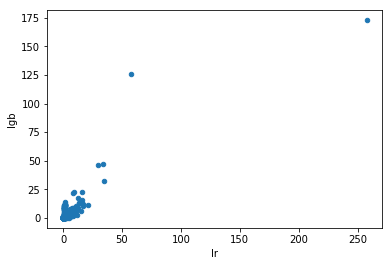

In [34]:
# YOUR CODE GOES HERE
pd.DataFrame(X_test_level2, columns=['lr', 'lgb']).plot.scatter('lr', 'lgb')

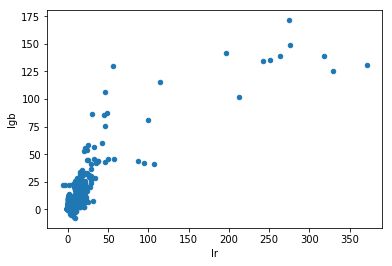

In [35]:
pd.DataFrame(X_train_level2, columns=['lr', 'lgb']).plot.scatter('lr', 'lgb')

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

### ヒント  
After yo get the X_train_level2, just use the given formula to add them up and get the r2 score using the sum and the y_train_level2 and then optimize it on alpha i.e. use the best_alpha as one which maximizes your r2 score.

### 1つのαで試してみる

In [36]:
X_train_level2df = pd.DataFrame(X_train_level2, columns=['lr', 'lgb'])
X_train_level2df.head(3)

,lr,lgb
0,1.191557,1.318545
1,1.035172,0.991283
2,1.556856,1.133751


In [37]:
X_train_level2df.shape

(34404, 2)

In [38]:
alpha = 0.001

mix = alpha*X_train_level2df['lr'] + (1 - alpha)*X_train_level2df['lgb']

r2 = r2_score(y_train_level2, mix)
r2

0.47142713181186047

### ここまで--------------------------

In [39]:
r2_res = []
alphas_to_try = np.linspace(0, 1, 1001)

for alpha in tqdm_notebook(alphas_to_try):
    mix = alpha*X_train_level2df['lr'] + (1 - alpha)*X_train_level2df['lgb']
    r2_tmp = r2_score(y_train_level2, mix)
    r2_res.append(r2_tmp)

A Jupyter Widget

In [40]:
max(r2_res)

0.62725504344615479

In [41]:
r2_res.index(max(r2_res))

765

In [42]:
alphas_to_try[765]

0.76500000000000001

In [43]:
# alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = alphas_to_try[765] # YOUR CODE GOES HERE
r2_train_simple_mix = max(r2_res) # YOUR CODE GOES HERE

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [45]:
X_test_level2df = pd.DataFrame(X_test_level2, columns=['lr', 'lgb'])
X_test_level2df.head(3)

,lr,lgb
0,13.458962,13.378315
1,3.185994,2.555902
2,2.502821,1.523568


In [46]:
X_test_level2df.shape

(3354, 2)

In [47]:
mix_test = best_alpha*X_test_level2df['lr'] + (1 - best_alpha)*X_test_level2df['lgb']

In [50]:
mix_test[0:10]

0    13.440010
1     3.037923
2     2.272697
3     1.427641
4     1.028987
5    14.284065
6    37.356514
7     0.886312
8     1.709430
9     3.273226
dtype: float64

In [51]:
y_test[0:10]

array([ 21.,  13.,   2.,   1.,   1.,  18.,  35.,   1.,   1.,   2.], dtype=float32)

In [52]:
r2_score(y_test, mix_test)

0.78114416957903532

In [53]:
test_preds = mix_test # YOUR CODE GOES HERE
r2_test_simple_mix = r2_score(y_test, mix_test) # YOUR CODE GOES HERE

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [59]:
# YOUR CODE GOES HERE
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [61]:
train_preds = lr.predict(X_train_level2) # YOUR CODE GOES HERE
r2_train_stacking = r2_score(y_train_level2, train_preds) # YOUR CODE GOES HERE

test_preds = lr.predict(X_test_level2)# YOUR CODE GOES HERE
r2_test_stacking = r2_score(y_test, test_preds) # YOUR CODE GOES HERE

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [62]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.765
Current answer for task r2_train_simple_mix is: 0.627255043446
Current answer for task r2_test_simple_mix is: 0.781144169579
Current answer for task r2_train_stacking is: 0.632175561459
Current answer for task r2_test_stacking is: 0.771297132342


In [63]:
STUDENT_EMAIL = 'hogefuga'# EMAIL HERE
STUDENT_TOKEN = 'hogefuga'# TOKEN HERE
grader.status()

You want to submit these numbers:
Task best_alpha: 0.765
Task r2_train_simple_mix: 0.627255043446
Task r2_test_simple_mix: 0.781144169579
Task r2_train_stacking: 0.632175561459
Task r2_test_stacking: 0.771297132342


In [64]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
